In [1]:
import os
from collections import Counter

import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn_crfsuite import metrics
from src.articles_extraction import ArticlesExtraction
from src.sequence_tagger import CRFSequenceClassifier, GRUTagger, Dataset, train_model, evaluate, convert_data
from src.terms_extraction import RuleBasedExtractor
from src.texts_annotation import Annotator, TerminologyTree, fill_terminology_tree

## Articles extraction

In [2]:
artextr = ArticlesExtraction(30, save_txt=False, save_pdf=False)
articles = artextr.extract()
texts = [x for x in list(articles.values())]


Getting the links for 30 articles...
Getting the texts...


In [3]:
train = texts[:20]  # 20 articles for training
test = texts[20:]  # 10 articles for testing

## Rule-based terms extraction

In [4]:
r = RuleBasedExtractor()
all_terms = r.extract(train)


In [5]:
print(f'Number of extracted terms: {len(all_terms)}')

Number of extracted terms: 23977


In [6]:
print('10 first extracted terms')
for num, term in enumerate(all_terms[:10]):
    print(f'{num + 1}. {term}')


10 first extracted terms
1. tropical forest
2. mature tropical forest
3. many mature tropical forest
4. ecological significance
5. p stock
6. stock as soil
7. soil age
8. tropical forest
9. forest soil
10. various form


Saving 200 the most popular terms in 'data/auto_popular_terms.txt'

In [7]:
if not os.path.exists('data/'):
    os.mkdir('data')

popular_terms = Counter([x.lower() for x in all_terms]).most_common(200)
with open('data/auto_popular_terms.txt', 'w', encoding='utf-8') as autoterms:
    for term in popular_terms:
        autoterms.write(term[0] + '\n')


Filtered terms extraction

In [8]:
# there are more terms both in manual_popular_terms and auto_popular_terms, as we filtered the terms several times on different articles, 
# so we decided to add all already extracted terms to the end of these files
with open('data/manual_popular_terms.txt', encoding='utf-8') as terms:
    terms = terms.read().split('\n')

In [9]:
print(f'Number of terms before manual filtering: {len(popular_terms)}')
print(f'Number of terms after manual filtering: {len(terms)}')


Number of terms before manual filtering: 200
Number of terms after manual filtering: 205


## Datasets annotation

In [10]:
anno = Annotator()
tree = TerminologyTree()
terminology = [t.split(' ') for t in terms]
fill_terminology_tree(terminology, tree)
annotated_train = [anno.annotate(tree, text) for text in train]
annotated_test = [anno.annotate(tree, text) for text in test]

## Tagging with supervised learning algorithm

CRF sequence classifier training

In [11]:
seq = CRFSequenceClassifier()
X_train, y_train = seq.convert_corpus(annotated_train)
model = seq.fit(X_train, y_train)
labels = list(model.classes_)

Computing model's predictions

In [12]:
X_test, y_test = seq.convert_corpus(annotated_test)
y_pred = model.predict(X_test)
score = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
print(f'F1-score weighted: {score}')

F1-score weighted: 0.993382049840628


In [13]:
flat_y_test = sum(y_test, [])
flat_y_pred = sum(y_pred, [])

Classification report

In [14]:
class_report = classification_report(y_true=flat_y_test, y_pred=flat_y_pred, labels=labels)
print(class_report)

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     67972
           B       0.81      0.38      0.51       266
           I       0.82      0.37      0.51       276

    accuracy                           0.99     68514
   macro avg       0.87      0.58      0.67     68514
weighted avg       0.99      0.99      0.99     68514



Confusion matrix

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

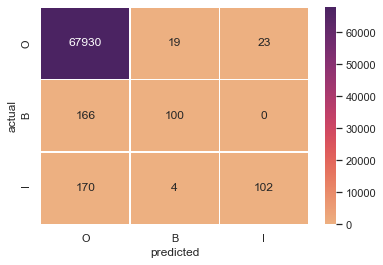

In [15]:
conf_mat = confusion_matrix(flat_y_test, flat_y_pred, labels=labels)
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels,
                     yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')

Neural Network classifier training (GRU)

In [16]:
training_data = convert_data(annotated_train)
testing_data = convert_data(annotated_test)
word_to_ix = {'UNK': 0}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [17]:
% % capture
alllabels = sum([x[1] for x in training_data], [])
weights = compute_class_weight('balanced', ['O', 'B', 'I'], alllabels)

In [18]:
print(weights)

[ 0.34129696 28.90076869 28.24931694]


In [19]:
trainds = Dataset(training_data, word_to_ix)
testds = Dataset(testing_data, word_to_ix)

train_dataloader = torch.utils.data.DataLoader(trainds, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(testds, batch_size=1)

In [24]:
model = GRUTagger(100, 100, len(word_to_ix), 3)
model.train()
loss_function = nn.CrossEntropyLoss(weight=torch.tensor([0.34070931, 31.16578749, 30.43193525]))
optimizer = optim.SGD(model.parameters(), lr=0.1)
model = train_model(model, train_dataloader, loss_function, optimizer, 6)

1/6


loss: 0.147: 100%|██████████| 5399/5399 [00:34<00:00, 155.46it/s]


2/6


loss: 0.113: 100%|██████████| 5399/5399 [00:33<00:00, 161.13it/s]


3/6


loss: 0.117: 100%|██████████| 5399/5399 [00:34<00:00, 154.47it/s]


4/6


loss: 0.127: 100%|██████████| 5399/5399 [00:36<00:00, 147.57it/s]


5/6


loss: 0.136: 100%|██████████| 5399/5399 [00:36<00:00, 146.77it/s]


6/6


loss: 0.14: 100%|██████████| 5399/5399 [00:36<00:00, 146.77it/s]


In [25]:
pred, true = evaluate(model, test_dataloader)

100%|██████████| 2973/2973 [00:04<00:00, 625.45it/s]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     67971
           1       0.30      0.33      0.31       266
           2       0.79      0.35      0.49       276

    accuracy                           0.99     68513
   macro avg       0.70      0.56      0.60     68513
weighted avg       0.99      0.99      0.99     68513



[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

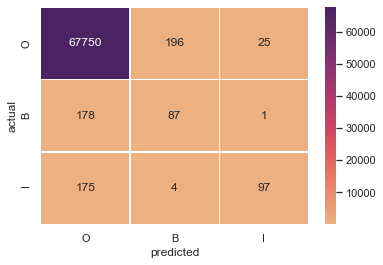

In [26]:
conf_mat = confusion_matrix(true, pred, labels=[0, 1, 2])
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels,
                     yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')